<a href="https://colab.research.google.com/github/Rstam59/ds-portfolio/blob/main/Real%26Fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rustemaliyev","key":"6a6efbf32f807152e157930b660d532e"}'}

In [2]:
# Make a directory for kaggle and move the file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle CLI tool
!pip install -q kaggle


In [3]:
# Download the dataset using Kaggle CLI
!kaggle datasets download -d razanaqvi14/real-and-fake-news

# Unzip the dataset
!unzip real-and-fake-news.zip


Dataset URL: https://www.kaggle.com/datasets/razanaqvi14/real-and-fake-news
License(s): CC-BY-NC-SA-4.0
  0% 0.00/41.0M [00:00<?, ?B/s]
100% 41.0M/41.0M [00:00<00:00, 1.12GB/s]
Archive:  real-and-fake-news.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [4]:
import pandas as pd

real_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")


real_df['label'] = 1
fake_df['label'] = 0

df = pd.concat([real_df, fake_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0
...,...,...,...,...,...
44893,Nigeria says U.S. agrees delayed $593 million ...,ABUJA (Reuters) - The United States has formal...,worldnews,"December 27, 2017",1
44894,Boiler Room #62 – Fatal Illusions,Tune in to the Alternate Current Radio Network...,Middle-east,"June 29, 2016",0
44895,ATHEISTS SUE GOVERNOR OF TEXAS Over Display on...,I m convinced the Freedom From Religion group...,Government News,"Feb 27, 2016",0
44896,Republican tax plan would deal financial hit t...,WASHINGTON (Reuters) - The Republican tax plan...,politicsNews,"November 2, 2017",1


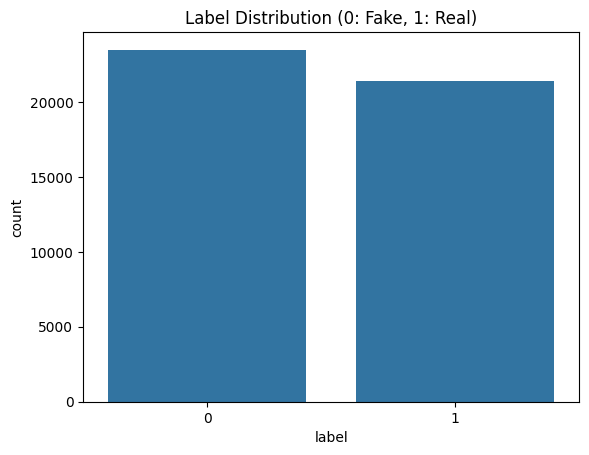

label
0    0.522985
1    0.477015
Name: proportion, dtype: float64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x='label')
plt.title("Label Distribution (0: Fake, 1: Real)")
plt.show()

print(df['label'].value_counts(normalize=True))

In [6]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


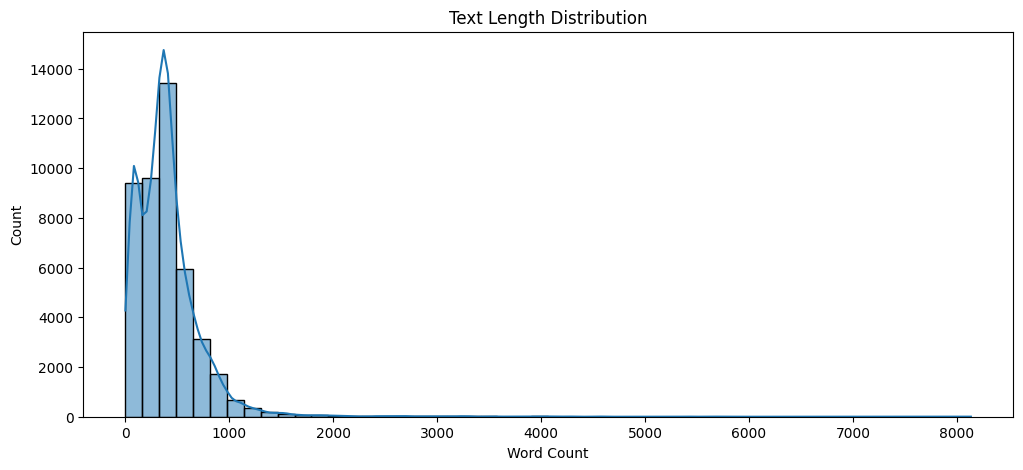

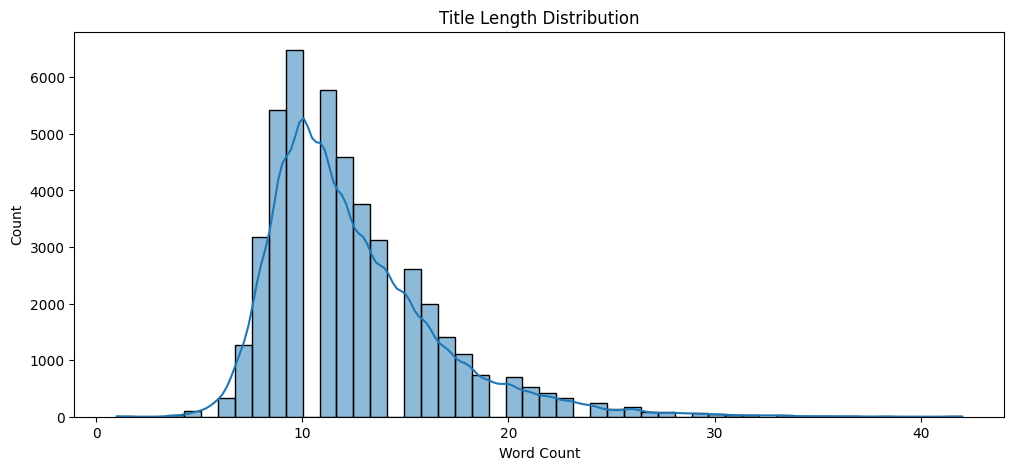

In [7]:
df['text_len'] = df['text'].apply(lambda x: len(x.split()))
df['title_len'] = df['title'].apply(lambda x: len(x.split()))


plt.figure(figsize=(12, 5))
sns.histplot(df['text_len'], bins=50, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Word Count")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df['title_len'], bins=50, kde=True)
plt.title("Title Length Distribution")
plt.xlabel("Word Count")
plt.show()

In [8]:
print("Unique subjects:", df['subject'].unique())
print(df['subject'].value_counts())


Unique subjects: ['News' 'politicsNews' 'politics' 'worldnews' 'Government News'
 'left-news' 'Middle-east' 'US_News']
subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


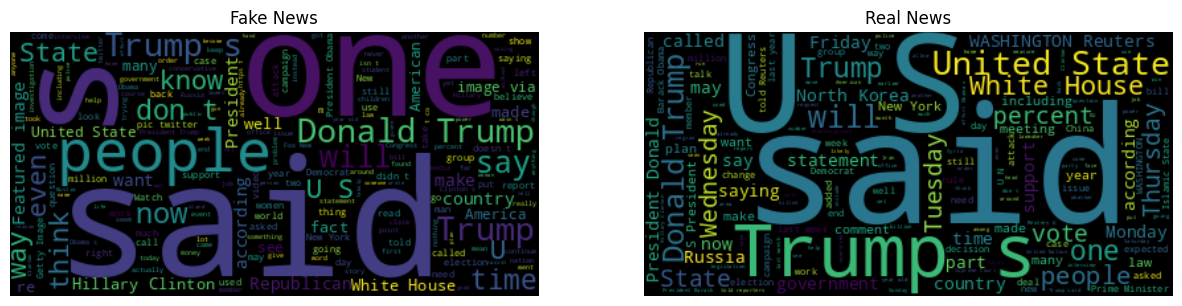

In [9]:
from wordcloud import WordCloud

# Join all fake and real text
fake_text = " ".join(df[df['label']==0]['text'].astype(str).tolist())
real_text = " ".join(df[df['label']==1]['text'].astype(str).tolist())

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
WordCloud(max_words=200, background_color="white").generate(fake_text)
plt.imshow(WordCloud().generate(fake_text), interpolation='bilinear')
plt.title("Fake News")
plt.axis("off")

plt.subplot(1, 2, 2)
WordCloud(max_words=200, background_color="white").generate(real_text)
plt.imshow(WordCloud().generate(real_text), interpolation='bilinear')
plt.title("Real News")
plt.axis("off")

plt.show()


#Vectorization

In [10]:
len(df)

44898

In [11]:
import re
from sklearn.model_selection import train_test_split


df['content'] = df['title'] + ' ' + df['text']


def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df['clean_content'] = df['content'].apply(clean_text)
df = df.drop_duplicates(subset='clean_content')

X_train, X_val, y_train, y_val = train_test_split(
    df['clean_content'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [12]:
from tensorflow.keras.layers import TextVectorization

MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 1200

vectorizer = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)


vectorizer.adapt(X_train.values)


In [13]:
import tensorflow as tf

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE


train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_ds = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))

train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input

# Constants
EMBEDDING_DIM = 128

# Build model
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 1200)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 1200, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,667,137 (10.17 MB)

 Trainable params: 2,667,137 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
EPOCHS = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/5
977/977 ━━━━━━━━━━━━━━━━━━━━ 84s 80ms/step - accuracy: 0.9482 - loss: 0.1062 - val_accuracy: 0.9992 - val_loss: 0.0050
Epoch 2/5
977/977 ━━━━━━━━━━━━━━━━━━━━ 78s 80ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.9980 - val_loss: 0.0088
Epoch 3/5
977/977 ━━━━━━━━━━━━━━━━━━━━ 78s 80ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9990 - val_loss: 0.0052
Epoch 4/5
977/977 ━━━━━━━━━━━━━━━━━━━━ 78s 79ms/step - accuracy: 0.9999 - loss: 5.0498e-04 - val_accuracy: 0.9988 - val_loss: 0.0060
Epoch 5/5
977/977 ━━━━━━━━━━━━━━━━━━━━ 78s 80ms/step - accuracy: 1.0000 - loss: 9.4040e-05 - val_accuracy: 0.9992 - val_loss: 0.0066


In [16]:
loss, acc = model.evaluate(val_ds)
print(f"\nValidation Accuracy: {acc:.4f}")
print(f"Validation Loss: {loss:.4f}")


245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9995 - loss: 0.0038

Validation Accuracy: 0.9992
Validation Loss: 0.0066


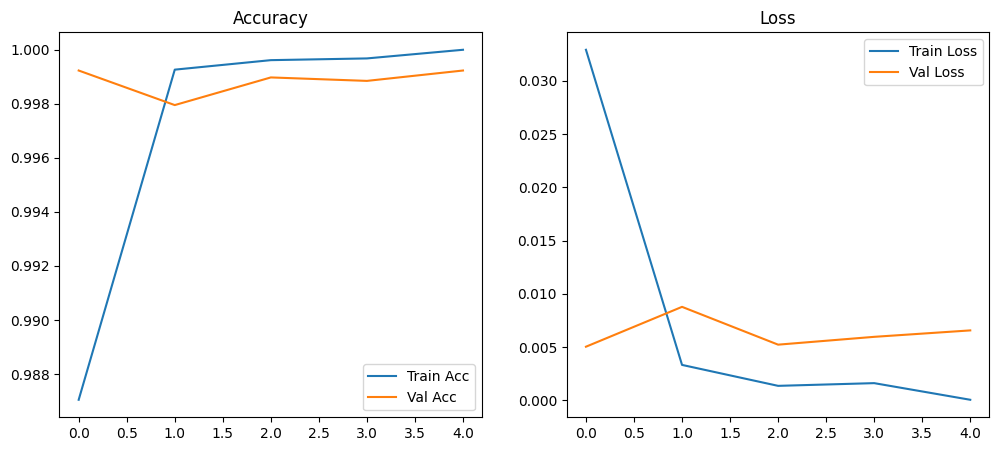

In [17]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)


In [18]:
preds = model.predict(val_ds)
y_pred = (preds > 0.5).astype(int)

245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step


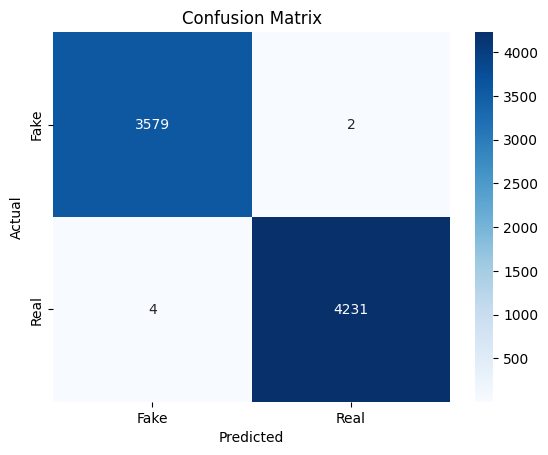

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [20]:
def predict_sample(text):
    text = clean_text(text)
    text = tf.constant([text])
    pred = model.predict(text)[0][0]
    label = "Real" if pred > 0.5 else "Fake"
    print(f"Prediction: {label} ({pred:.2f})")


predict_sample("President signs a new healthcare bill into law.")
predict_sample("BREAKING: Aliens seen entering the White House.")
predict_sample("The quick brown fox jumps over the lazy dog.")
predict_sample('state dept subpoenaed documents from clinton foundation report washington reuters us state department investigators last year issued a subpoena to the bill hillary and chelsea clinton foundation seeking documents about projects run by the charity that may have required us government approval when hillary clinton was secretary of state the washington post reported on thursday a us official said the matter was being investigated by the inspector general the state departments internal watchdog citing unnamed sources for the report the post said the subpoena issued in the fall also asked for records related to senior clinton aide huma abedin who for six months in simultaneously worked for several employers including the state department the foundation and clintons personal office the report follows a reuters investigation last year that found the clinton foundations flagship health project did not submit new or increased payments from at least seven foreign governments to the state department for review in breach of the ethics agreement clinton signed with the incoming obama administration in order to become secretary of state clinton who is running for the democratic nomination in the nov presidential election has been criticized for using a private email account hosted on a private computer while secretary of state from to a matter the fbi is investigating spokesmen for clintons campaign and the clinton foundation and a lawyer for abedin did not immediately respond to reuters requests for comment a spokesman for the inspector general also declined to comment the post quoted an unnamed foundation representative as saying the initial document request had been narrowed by investigators and that the foundation was not the focus of the probe it said there was no indication that the investigators were looking at clinton the full scope and status of the inquiry conducted by the state departments inspector general were not clear from the material correspondence reviewed by the washington post the paper said sources familiar with investigations into the controversy surrounding clintons private email server said they had no reason to believe any government agency was conducting any kind of inquiry into possible criminal violations related to the former secretary of state')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
Prediction: Fake (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction: Fake (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction: Fake (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction: Real (1.00)


In [21]:
X_val.iloc[0]

'no northsouth ireland border despite leaving customs union british minister pledges berlin reuters there will never again be a border dividing northern ireland and the republic a british minister said days before a summit at which the irish border issue threatens to derail britain s brexit plans but in the interview with the rheinische post newspaper international trade minister greg hands reaffirmed that britain would quit the european union s customs union a move most experts believe would lead to the reimposition of a border currently both parts of the island are members of the same customs union meaning checks of goods crossing the border are unnecessary if britain left the customs union and no new checks were imposed many experts warn it would create a backdoor route to circumvent eu tariffs as part of its negotiations to quit the european union britain must satisfy the bloc s remaining members that it has settled issues including its financial obligations citizens rights and mai

In [22]:
y_val.iloc[0]

np.int64(1)

In [23]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [24]:
!pip install --upgrade transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [25]:
from datasets import Dataset

train_ds = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train}))
val_ds = Dataset.from_pandas(pd.DataFrame({'text': X_val, 'label': y_val}))

In [26]:
train_ds

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 31264
})

In [27]:
def tokenize(example):
    return tokenizer(example['text'], truncation=True, padding='longest')


train_ds = train_ds.map(tokenize, batched = True)
val_ds = val_ds.map(tokenize, batched = True)

Map:   0%|          | 0/31264 [00:00<?, ? examples/s]

Map:   0%|          | 0/7816 [00:00<?, ? examples/s]

In [28]:
train_ds.set_format('torch', columns = ['input_ids', 'attention_mask', 'label'])
val_ds.set_format('torch', columns = ['input_ids', 'attention_mask', 'label'])

In [29]:
train_ds = train_ds.remove_columns(['text', '__index_level_0__'])
val_ds = val_ds.remove_columns(['text', '__index_level_0__'])

In [30]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,  # Enable mixed precision
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted')
    }


trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    compute_metrics = compute_metrics
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rustam-skilledin to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.005000,0.004269,0.999488,0.999488
2,0.002000,0.002203,0.999744,0.999744
3,0.000100,0.002238,0.999616,0.999616


TrainOutput(global_step=5862, training_loss=0.0062550185435727695, metrics={'train_runtime': 258.8052, 'train_samples_per_second': 362.404, 'train_steps_per_second': 22.65, 'total_flos': 1.2424382254743552e+16, 'train_loss': 0.0062550185435727695, 'epoch': 3.0})

In [32]:
metrics = trainer.evaluate()
print(metrics)

# Save model
model.save_pretrained("fake-news-bert-model")
tokenizer.save_pretrained("fake-news-bert-model")


{'eval_loss': 0.002203072654083371, 'eval_accuracy': 0.9997441146366428, 'eval_f1': 0.9997441201369457, 'eval_runtime': 5.4409, 'eval_samples_per_second': 1436.517, 'eval_steps_per_second': 89.874, 'epoch': 3.0}


('fake-news-bert-model/tokenizer_config.json',
 'fake-news-bert-model/special_tokens_map.json',
 'fake-news-bert-model/vocab.txt',
 'fake-news-bert-model/added_tokens.json',
 'fake-news-bert-model/tokenizer.json')

In [33]:
!pip install -q lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [35]:
from transformers import TextClassificationPipeline
from lime.lime_text import LimeTextExplainer
import torch

# Wrap the trained model into a pipeline
pipeline = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    top_k=None,
    device=0 if torch.cuda.is_available() else -1
)


Device set to use cuda:0


In [44]:
explainer = LimeTextExplainer(class_names=["Fake", "Real"])

# Example input
text = "President Trump Said I love Unicorns and they are 100% Real!"

# Explain
exp = explainer.explain_instance(
    text_instance=text,
    classifier_fn=lambda x: np.array([[score['score'] for score in sorted(p, key=lambda y: y['label'])] for p in pipeline(x)]),
    num_features=10
)

# Show Explanation
exp.show_in_notebook(text=True)

t


In [55]:
from accelerate import Accelerator
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch
from tqdm.auto import tqdm


accelerator = Accelerator()
device = accelerator.device

train_loader = DataLoader(train_ds, shuffle = True, batch_size = 16)
eval_loader = DataLoader(val_ds, batch_size = 16)

optimizer = AdamW(model.parameters(), lr = 2e-5)

model, optimizer, train_loader, eval_loader = accelerator.prepare(model,
                                                                  optimizer, train_loader, eval_loader)

model.train()
for epoch in range(3):
    loop = tqdm(train_loader, desc = f"Epoch {epoch}")
    for batch in loop:
        optimizer.zero_grad()
        batch['labels'] = batch.pop('label')
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        optimizer.step()

    print(f"Epoch {epoch} loss: {loss.item()}")

Epoch 0:   0%|          | 0/1954 [00:00<?, ?it/s]

Epoch 0 loss: 3.345310688018799e-05


Epoch 1:   0%|          | 0/1954 [00:00<?, ?it/s]

Epoch 1 loss: 4.616379737854004e-05


Epoch 2:   0%|          | 0/1954 [00:00<?, ?it/s]

Epoch 2 loss: 1.2271106243133545e-05


In [56]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in eval_loader:
        batch['labels'] = batch.pop('label')
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim = -1).detach().cpu().numpy()
        labels = batch['labels'].detach().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)



acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc}")

Accuracy: 0.9998720573183214
